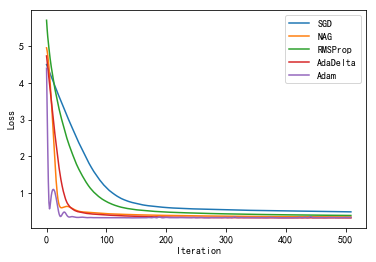

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
-------------------------------------------------
   File Name：     LogisticRegressionWithSGD
   Description :
   Author :       Nathan
   date：          2017/12/4
-------------------------------------------------
   Change Activity:
                   2017/12/4:
-------------------------------------------------
"""
__author__ = 'Nathan'

from sklearn.datasets import load_svmlight_file
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

feature_num=123
batch_size=128
SGD_methods=["SGD","NAG","RMSProp","AdaDelta","Adam"]
parm={"SGD":{"learning rate":0.01},\
      "NAG":{"learning rate":0.01,"Gamma":0.9},\
      "RMSProp":{"learning rate":0.01,"Gamma":0.9,"Epsilon":10e-8},\
      "AdaDelta":{"Gamma":0.95,"Epsilon":10e-6},\
      "Adam":{"Beta":0.9,"Gamma":0.999,"learning rate":0.1,"Epsilon":10e-8}}
temp_list={"NAG":np.zeros([feature_num + 1, 1]),\
           "RMSProp":np.zeros([feature_num+1,1]),\
           "AdaDelta":{"EG":np.zeros([feature_num+1,1]),"EX":np.zeros([feature_num+1,1])},\
           "Adam":{"M":np.zeros([feature_num+1,1]),"G":np.zeros([feature_num+1,1]),"t":0}}
def sigmoid(z):
    return 1/(1+np.exp(-1.0*z))

def compute_loss(W, X_test,y_test):
    logits = np.matmul(X_test, W)
    loss = -np.mean(y_test * np.log(sigmoid(logits)) + (1 - y_test) * np.log(1 - sigmoid(logits)))
    return loss

def compute_gradient(W,X_train,y_train):
    logits = np.matmul(X_train, W)
    output = sigmoid(logits)
    error = output - y_train
    gradient = np.matmul(X_train.transpose(), error) / y_train.shape[0]
    return gradient

def SGD(W,X_train,y_train):
    W-=parm.get("SGD").get("learning rate")*compute_gradient(W,X_train,y_train)
    return W

def NAG(W,X_train,y_train):
    global temp_list
    global parm
    momentum=temp_list.get('NAG')
    #learning_rate=parm.get("NAG").get("learning_rate")
    Gamma=parm.get("NAG").get("Gamma")
    gradient=compute_gradient(W-(Gamma*momentum),X_train,y_train)
    update_momentum = momentum * Gamma+ gradient * parm.get("NAG").get("learning rate")
    temp_list["NAG"]=update_momentum
    W-=update_momentum
    return W

def RMSProp(W,X_train,y_train):
    G=temp_list.get("RMSProp")
    Gamma =parm.get("RMSProp").get("Gamma")
    Epsilon=parm.get("RMSProp").get("Epsilon")
    learning_rate=parm.get("RMSProp").get("learning rate")
    gradient=compute_gradient(W,X_train,y_train)
    G=G+(1-Gamma)*gradient**2
    temp_list["RMSProp"]=G
    W-=learning_rate*gradient/np.sqrt(G+Epsilon)
    return W

def AdaDelta(W,X_train,y_train):
    EG=temp_list.get("AdaDelta").get("EG")
    EX=temp_list.get("AdaDelta").get("EX")
    Gamma=parm.get("AdaDelta").get("Gamma")
    Epsilon=parm.get("AdaDelta").get("Epsilon")
    gradient=compute_gradient(W,X_train,y_train)
    EG=Gamma*EG+(1-Gamma)*gradient**2
    temp_list.get("AdaDelta")["EG"]=EG
    delta=-1*gradient*np.sqrt(EX+Epsilon)/np.sqrt(EG+Epsilon)
    EX=Gamma*EX+(1-Gamma)*delta**2
    temp_list.get("AdaDelta")["EX"]=EX
    W+=delta
    return W

def Adam(W,X_train,y_train):
    Beta=parm.get("Adam").get("Beta")
    Gamma=parm.get("Adam").get("Gamma")
    Epsilon=parm.get("Adam").get("Epsilon")
    learning_rate=parm.get("Adam").get("learning rate")
    M=temp_list.get("Adam").get("M")
    G=temp_list.get("Adam").get("G")
    t=temp_list.get("Adam").get("t")
    t=t+1
    temp_list.get("Adam")["t"]=t
    gradient=compute_gradient(W,X_train,y_train)
    M=Beta*M+(1-Beta)*gradient
    temp_list.get("Adam")["M"]=M
    G=Gamma*G+(1-Gamma)*gradient**2
    temp_list.get("Adam")["G"]=G
    M_bias=M/(1-Beta**t)
    G_bias=G/(1-Gamma**t)
    W-=learning_rate*M_bias/(np.sqrt(G_bias)+Epsilon)
    return W

def opitimizer(W,X_train,y_train,method):
    if method=="SGD":
        return SGD(W,X_train,y_train)
    if method=="NAG":
        return NAG(W,X_train,y_train)
    if method=="RMSProp":
        return RMSProp(W,X_train,y_train)
    if method=="AdaDelta":
        return AdaDelta(W,X_train,y_train)
    if method=="Adam":
        return Adam(W,X_train,y_train)

def getdata():
    X_train, y_train = load_svmlight_file(r'C:\Users\jy\Desktop\Libsvmdata\a9a.txt')
    datasize,features=X_train.shape
    X_train=np.c_[np.ones(len(X_train.toarray())), X_train.toarray()]
    for i in range(0, len(y_train)):
        if y_train[i] == -1:
            y_train[i] = 0
    X_test,y_test=load_svmlight_file(r'C:\Users\jy\Desktop\Libsvmdata\a9a_test.txt')
    X_test=np.c_[X_test.toarray(),np.zeros(len(X_test.toarray()))]
    X_test=np.c_[np.ones(len(X_test)),X_test]
    for i in range(0, len(y_test)):
        if y_test[i] == -1:
            y_test[i] = 0
    y_train = y_train.reshape([len(y_train), 1])
    y_test = y_test.reshape([len(y_test), 1])
    X_train,y_train=shuffle(X_train,y_train)
    X_test,y_test=shuffle(X_test,y_test)
    return X_train,y_train,X_test,y_test,datasize,features

def get_sub_batch(batch_count,X,y,data_size):
    if (1+batch_count)*batch_size<=data_size:
        return X[batch_count*batch_size:(batch_count + 1) * batch_size],y[batch_count*batch_size:(batch_count + 1) * batch_size]
    else:
        return X[batch_count*batch_size:data_size],y[batch_count*batch_size:data_size]

def shuffle(X,y):
    rng_state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(rng_state)
    np.random.shuffle(y)
    return X,y

def LogisicRegressionModel():
    X_train, y_train, X_test, y_test, data_size, features_num = getdata()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    for method in SGD_methods:
        W = np.random.rand(features_num + 1, 1)
        iter_ = []
        error = []
        num = 0
        for j in range(2):
            for i in range(0, int(data_size / batch_size ) + 1):
                iter_.append(num)
                X,y=get_sub_batch(i,X_train,y_train,data_size)
                W=opitimizer(W,X,y,method)
                error.append(compute_loss(W,X_test,y_test))
                num+=1
        plt.plot(iter_, error, label=method)
    plt.legend()
    plt.show()

LogisicRegressionModel()